In [1]:
!pip install -Uqq -r requirements.txt

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [3]:
from pathlib import Path
import pandas as pd
path  = Path.cwd()
path

Path('/notebooks/CollaborativeFiltering')

In [4]:
ratings = pd.read_csv(path/'data'/'rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
movies = pd.read_csv(path/'data'/'movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [7]:
ratings.shape

(20000263, 6)

In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name = 'title', bs = 64)
dls.show_batch()

,userId,title,rating
0,18255,"Blues Brothers, The (1980)",5.0
1,55691,Waterworld (1995),3.0
2,91931,Christmas Vacation (National Lampoon's Christmas Vacation) (1989),4.0
3,39497,Close Encounters of the Third Kind (1977),3.5
4,92257,"Matrix Revolutions, The (2003)",0.5
5,103076,Glory (1989),3.0
6,117049,Face/Off (1997),4.0
7,60247,Groundhog Day (1993),4.0
8,13703,Stripes (1981),3.5
9,74609,"Rock, The (1996)",3.0


In [9]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [10]:
one_hot_3 = one_hot(3, n_users).float()

In [11]:
user_factors.t() @ one_hot_3

tensor([-0.8439, -0.0255, -0.5745,  0.6977,  0.3907])

In [12]:
user_factors[3]

tensor([-0.8439, -0.0255, -0.5745,  0.6977,  0.3907])

In [13]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)
        

In [14]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DotProduct(n_users, n_movies, 50).to(device)
# learn = Learner(dls=dls, model=model, loss_func=MSELossFlat())

In [16]:
# learn.fit_one_cycle(5, 5e-3)

In [17]:
# learn.export(path/'models'/'model_v1.pkl')

In [18]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range = (0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim = 1), *self.y_range)

In [19]:
# print(torch.cuda.memory_summary())

In [20]:
# model = DotProduct(n_users, n_movies, 25).to(device)
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(3, 5e-3)

In [21]:
# learn.export(path/'models'/'model_v2_sigmoid.pkl')

In [22]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [23]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range= (0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim = 1, keepdim = True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [24]:
# model = DotProductBias(n_users, n_movies, 25).to(torch.device('cuda'))
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(3, 5e-3)

In [25]:
# learn.export(path/'models'/'model_v3_bias.pkl')

In [26]:
# model = DotProductBias(n_users, n_movies, 25).to(torch.device('cuda'))
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3, wd = 0.1)

In [27]:
# learn.export(path/'models'/'model_v4_wt_decay.pkl')

### Creating Our Own Embedding Module

In [28]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [29]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [30]:
# model = DotProductBias(n_users, n_movies, 50).to(torch.device('cuda'))
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [31]:
# learn.export(path/'models'/'model_v5_with_own_embedding.pkl')

In [32]:
learn = load_learner(path/'models'/'model_v5_with_own_embedding.pkl')

### Interpreting Embeddings and Biases

In [49]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Battlefield Earth (2000)',
 'Speed 2: Cruise Control (1997)',
 'Spice World (1997)',
 'Home Alone 3 (1997)',
 'Anaconda (1997)']

For each of these movies, even when a user is very well matched to its latent factors, they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! 

In [50]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 "Schindler's List (1993)",
 'Godfather, The (1972)',
 'Silence of the Lambs, The (1991)']

So, for instance, even if you don't normally enjoy such movies, you might enjoy Schindler's List!

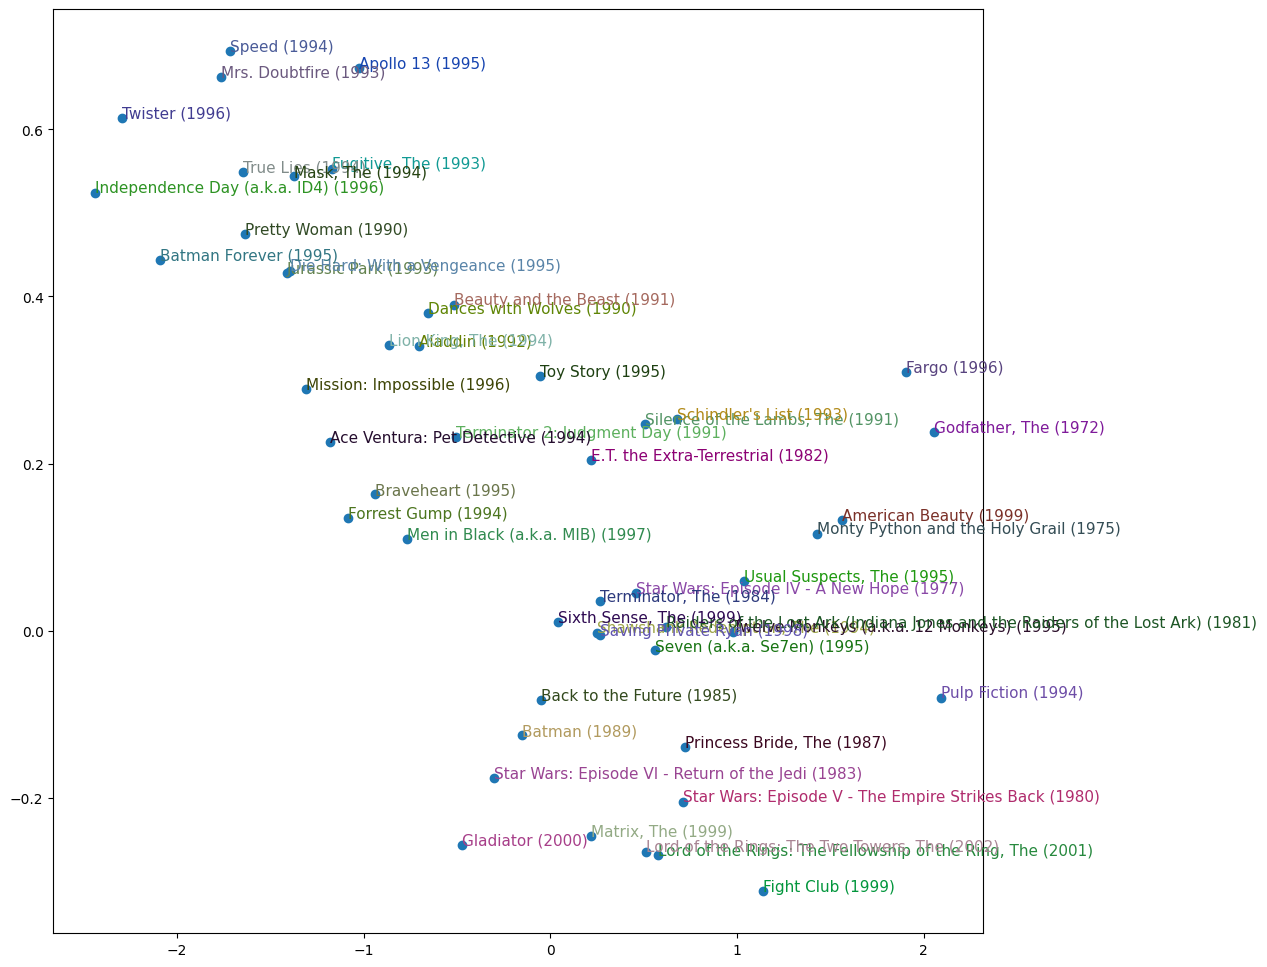

In [59]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [61]:
learn = collab_learner(dls, n_factors=25, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.949567,0.964383,34:44
1,0.987251,0.963855,34:51
2,0.951410,0.942808,35:40


In [ ]:
learn.export(path/'models'/'model_v6_using_fastai.pkl')